In [141]:
!../doDownload

!curl "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE217460&format=file&file=GSE217460%5F210322%5FTFAtlas%5Fdifferentiated%2Eh5ad%2Egz" -o "GSE217460_210322_TFAtlas_differentiated.h5ad.gz"
!curl "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE217460&format=file&file=GSE217460%5F210322%5FTFAtlas%5Fdifferentiated%5Fraw%2Eh5ad%2Egz" -o "GSE217460_210322_TFAtlas_differentiated_raw.h5ad.gz"

/bin/bash: ../doDownload: No such file or directory


In [1]:
import anndata
import pandas as pd
import csv

import cellrank as  cr
import scanpy as sc
from scipy import sparse

import umap
import copy as cp
    
import scipy.sparse as sp

from harmony import harmonize
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'anndata'

In [143]:
def calculate_entropy_per_tf(adata):
    # Count the frequency of each TF in each cluster
    frequency_table = adata.obs.groupby(['TF', 'difflouvain']).size().unstack(fill_value=0)
    
    # Convert counts to probabilities
    probabilities = frequency_table.div(frequency_table.sum(axis=1), axis=0)
    
    # Calculate entropy for each TF
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-9), axis=1)  # Adding a small value to avoid log(0)
    
    return entropy


def plot_umap(adata, pca_key='X_pca', umap_key='umap', title_prefix=''):
    # Initialize UMAP reducer
    reducer = umap.UMAP()

    # Fit the UMAP model using your selected PCA data
    embedding = reducer.fit_transform(adata.obsm[pca_key])

    # Store the UMAP embedding back into adata.obsm for later reference
    adata.obsm[umap_key] = embedding

    # Plot using Scanpy, specifying the basis as your custom UMAP
    sc.pl.umap(adata, color='difflouvain', title=f"{title_prefix} UMAP with {pca_key} as basis", legend_loc="on data")


def select_samples(adata, COUNT_VAR = 5, ENTROPY_VAR = 2.5):

    # Filter TF datapoints with number of counts greater than COUNT_VAR
    adata = adata[adata.obs['TF'].isin(adata.obs['TF'].value_counts()[adata.obs['TF'].value_counts() > COUNT_VAR].index), :]

    # Filter TFs with entropy over ENTROPY_VAR
    entropy_per_tf = calculate_entropy_per_tf(adata)
    adata = adata[adata.obs['TF'].isin(entropy_per_tf[entropy_per_tf < ENTROPY_VAR].index), :]

    return adata

def preprocess(adata):
    # Preprocessing
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    return adata

## SUESS


In [147]:
# still have to figure out what are the other TF-something-sample(n).files ? 


datafiles = [
    "GSM3308844_up-tf-stem-sample2.counts.tsv",
"GSM3308845_up-tf-stem-sample3.counts.tsv",
"GSM3308846_up-tf-endo-sample1.counts.tsv",
"GSM3308847_up-tf-endo-sample2.counts.tsv",
"GSM3308848_up-tf-multi-sample1.counts.tsv",
"GSM3308849_up-tf-multi-sample2.counts.tsv",
"GSM3308850_up-tf-klf.counts.tsv",
"GSM3308850_up-tf-myc.counts.tsv",
"GSM3308851_up-tf-neuron-hygro-sample1.counts.tsv",
"GSM3308852_up-tf-neuron-hygro-sample2.counts.tsv",
"GSM3308853_up-tf-neuron-nohygro-sample1.counts.tsv",
"GSM3308854_up-tf-neuron-nohygro-sample2.counts.tsv"
]

dictfiles = ["GSM3308844_up-tf-stem-sample2_pheno_dict.csv",
"GSM3308845_up-tf-stem-sample3_pheno_dict.csv",
"GSM3308846_up-tf-endo-sample1_pheno_dict.csv",
"GSM3308847_up-tf-endo-sample2_pheno_dict.csv",
"GSM3308848_up-tf-multi-sample1_pheno_dict.csv",
"GSM3308849_up-tf-multi-sample2_pheno_dict.csv",
"GSM3308850_up-tf-klf-myc_pheno_dict.csv",
"GSM3308851_up-tf-neuron-hygro-sample1_pheno_dict.csv",
"GSM3308852_up-tf-neuron-hygro-sample2_pheno_dict.csv",
"GSM3308853_up-tf-neuron-nohygro-sample1_pheno_dict.csv",
"GSM3308854_up-tf-neuron-nohygro-sample2_pheno_dict.csv"
]


def read_dict(filename):
    filepath = f"{dir}/{filename}"
    data_dict = {}
    with open(filepath, mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)
        
        # Skip the header row if your CSV has a header
        next(reader, None)  # Uncomment this line if your CSV file has a header
        
        # Iterate over the CSV rows
        for row in reader:
            key = row[0]
            value = row[1].strip('"')  # Strip double quotes from the value
            vallist = value.split(',')
            data_dict[key] = vallist
        
        return data_dict
    
    
def read_data_transposed(filename):
    filepath = f"{dir}/{filename}"
    df = pd.read_csv(filepath, delimiter='\t', header=0)
    
    # Ensure the DataFrame uses float64 data type
    df = pd.DataFrame(df, dtype=np.float64)

    # Transpose the DataFrame
    df_transposed = df.T

    # Extract column names and row names
    column_names = df_transposed.columns.tolist()
    row_names = df_transposed.index.tolist()

    # Extract data
    X = df_transposed.values

    # Create AnnData object
    adata = anndata.AnnData(X=X)

    # Add column and row names to adata
    adata.var_names = column_names
    adata.obs_names = row_names

    # Set batch information ensuring it is stored as categorical data
    adata.obs['batch'] = pd.Categorical([filename.split(".")[0]] * df_transposed.shape[0])

    return adata





In [148]:

datafiles = datafiles[2:4]
print(datafiles)
dictfiles = dictfiles[2:4]
print(dictfiles)

dir = "../data/SUESS"


['GSM3308846_up-tf-endo-sample1.counts.tsv', 'GSM3308847_up-tf-endo-sample2.counts.tsv']
['GSM3308846_up-tf-endo-sample1_pheno_dict.csv', 'GSM3308847_up-tf-endo-sample2_pheno_dict.csv']


## integrating dictionary

In [149]:
def runAndCombine(dataname, dictname):
    
    print(dataname)
    adata = read_data_transposed(dataname)
    adata = preprocess(adata)
    
    if not sp.issparse(adata.X):
        adata.X = sp.csr_matrix(adata.X)
    else:
        adata.X = adata.X

    dicted = read_dict(dictname)
    reverse_mapping = {key: [] for key in range(len(adata.obs_names))}

    for key, value in dicted.items():
        for v in value:
            reverse_mapping[adata.obs_names.get_loc(v)].append(key)

    # If you want to sort the keys in ascending order
    sorted_indices = sorted(reverse_mapping.keys())
    sorted_reverse_mapping = {idx: reverse_mapping[idx] for idx in sorted_indices}

    print("sorted_reverse_mapping:  ", sorted_reverse_mapping)
    print("length sorted reverse mapping: ", len(sorted_reverse_mapping))

    keys_with_multiple_values = [key for key, value in sorted_reverse_mapping.items() if len(value) > 1]
    print("indexes with multiple values:", keys_with_multiple_values)

    duplicated = [value for key in keys_with_multiple_values for value in sorted_reverse_mapping[key]]
    
    counted = Counter(duplicated)
    print("Times the TF is not alone:", counted)

    # Remove duplicate keys and keep only the first value if there are multiple
    sorted_reverse_mapping = {key: (None if len(value) != 1 else value[0]) for key, value in sorted_reverse_mapping.items()}

    
    assert len(sorted_reverse_mapping) == len(adata.obs_names)
    adata.obs["TF"] = sorted_reverse_mapping.values()
    adata = adata[adata.obs["TF"].notnull()]
    print(adata)
    return adata
        
# runAndCombine(datafiles[0], dictfiles[0])
one  = runAndCombine(datafiles[0], dictfiles[0])
two  = runAndCombine(datafiles[1], dictfiles[1])

# Saving batch labels
batch_labels_one = one.obs['batch'].tolist()
batch_labels_two = two.obs['batch'].tolist()





GSM3308846_up-tf-endo-sample1.counts.tsv
sorted_reverse_mapping:   {0: ['CDX2'], 1: ['SOX10'], 2: [], 3: ['LMX1A'], 4: [], 5: [], 6: [], 7: ['SNAI2'], 8: [], 9: [], 10: ['HOXA10'], 11: [], 12: [], 13: ['PAX7'], 14: [], 15: [], 16: [], 17: [], 18: ['POU1F1'], 19: ['NEUROG1'], 20: [], 21: ['ESRRG'], 22: ['ASCL1'], 23: ['TFAP2C'], 24: [], 25: ['HNF1A'], 26: [], 27: ['TBX5'], 28: [], 29: [], 30: ['GATA1'], 31: ['OTX2'], 32: [], 33: [], 34: ['SPI1'], 35: ['SOX3'], 36: [], 37: ['FOXP1'], 38: [], 39: [], 40: [], 41: [], 42: ['NEUROG3'], 43: [], 44: [], 45: [], 46: [], 47: ['POU5F1'], 48: [], 49: ['SNAI2'], 50: [], 51: [], 52: ['CRX', 'HAND2'], 53: [], 54: [], 55: ['KLF4'], 56: [], 57: [], 58: [], 59: [], 60: [], 61: [], 62: [], 63: [], 64: [], 65: ['HOXA11'], 66: ['GATA4'], 67: [], 68: ['SRY'], 69: [], 70: ['CDX2'], 71: ['HOXA10'], 72: [], 73: [], 74: [], 75: [], 76: [], 77: [], 78: ['mCherry'], 79: [], 80: ['MITF', 'FOXA2'], 81: [], 82: [], 83: [], 84: ['FOXP1'], 85: [], 86: ['LMX1A'], 87: [

In [ ]:
# SUESSdata = one.concat(two)
SUESSdata = anndata.AnnData.concatenate(one, two, index_unique=None)
SUESSdata.obs['batch'] = batch_labels_one + batch_labels_two


/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AAACCTGAGATAGCAT    GSM3308846_up-tf-endo-sample1
AAACCTGAGCGACGTA    GSM3308846_up-tf-endo-sample1
AAACCTGAGCTTCGCG    GSM3308846_up-tf-endo-sample1
AAACGGGTCTTCTGGC    GSM3308846_up-tf-endo-sample1
AAAGATGTCACTGGGC    GSM3308846_up-tf-endo-sample1
                                ...              
TTTGTCACATAGTAAG    GSM3308847_up-tf-endo-sample2
TTTGTCAGTACGAAAT    GSM3308847_up-tf-endo-sample2
TTTGTCATCACCGGGT    GSM3308847_up-tf-endo-sample2
TTTGTCATCTGTCAAG    GSM3308847_up-tf-endo-sample2
TTTGTCATCTTGGGTA    GSM3308847_up-tf-endo-sample2
Name: batch, Length: 4783, dtype: object

In [150]:
SUESSdata # go from about 10k to 5k samples

AnnData object with n_obs × n_vars = 4783 × 19081
    obs: 'batch', 'n_genes', 'TF'
    var: 'n_cells-0', 'n_cells-1'

## perform PCA and plot UMAP

In [151]:
# Perform PCA
adata = SUESSdata
sc.pp.pca(adata)

## should I use batch of batchTF here? 
adata.obsm["X_pca_harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="batch") # can use GPU

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
Reach convergence after 4 iteration(s).


In [152]:
sc.pp.neighbors(adata)

# Compute diffusion maps
sc.tl.diffmap(adata)

# Perform Louvain clustering on diffusion maps
sc.tl.louvain(adata, key_added='difflouvain')

/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


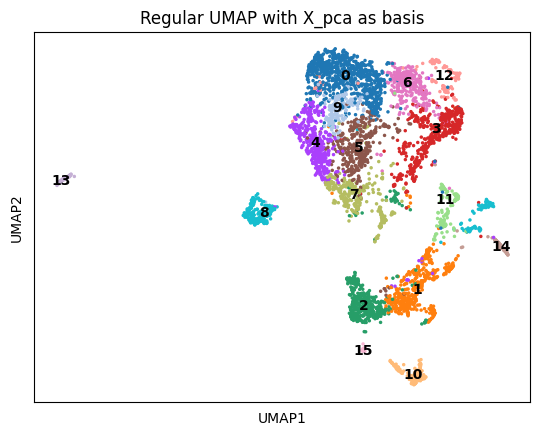

/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


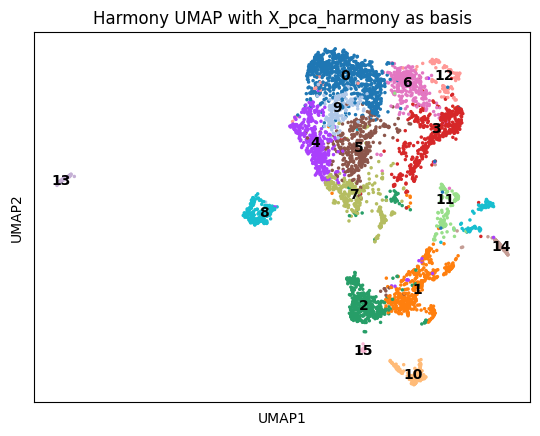

In [153]:
# Plot UMAP for regular PCA
plot_umap(adata, pca_key='X_pca', umap_key='umap', title_prefix='Regular')

# Plot UMAP for Harmony integrated PCA
plot_umap(adata, pca_key='X_pca_harmony', umap_key='X_umap_PCA_Harmony', title_prefix='Harmony')

### cell selections

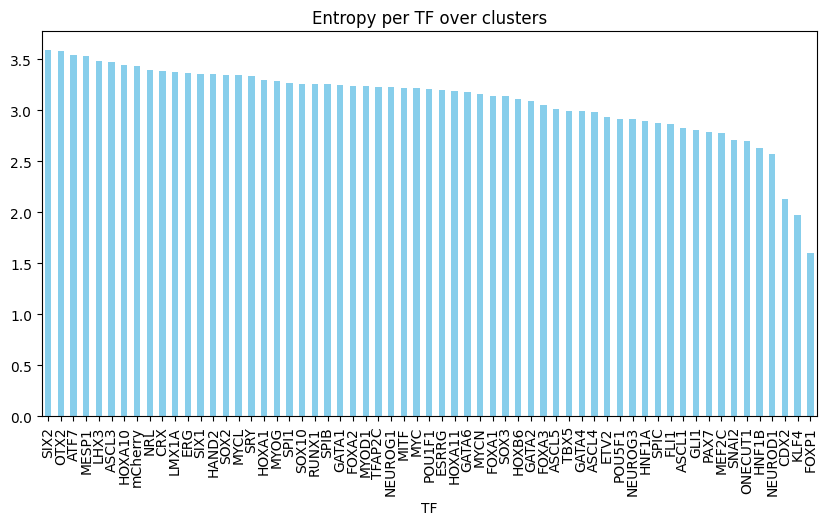

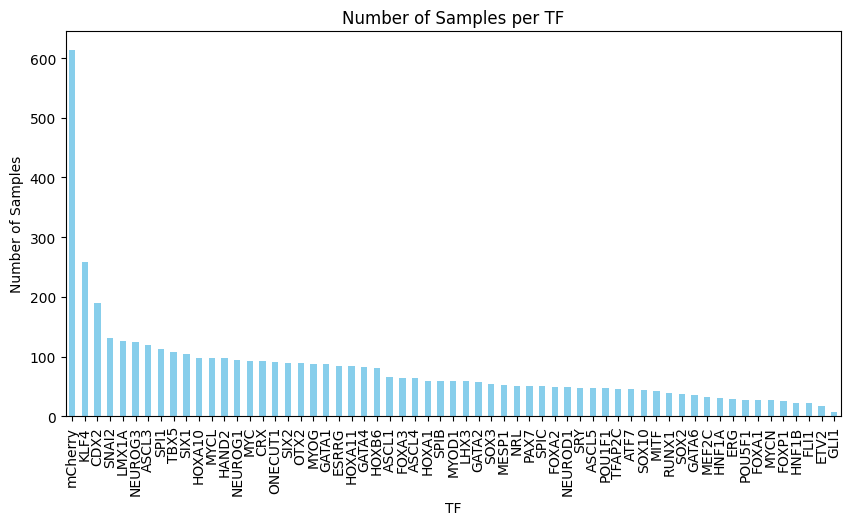

In [154]:
entropy_per_tf = calculate_entropy_per_tf(adata)
# print ordered histogram per TF
entropy_per_tf = entropy_per_tf.sort_values(ascending=False)
# plot histogram
entropy_per_tf.plot(kind='bar', figsize=(10, 5), color='skyblue', title='Entropy per TF over clusters')

# Count the number of samples per TF
sample_counts = adata.obs['TF'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 5))
sample_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Samples per TF')
plt.xlabel('TF')
plt.ylabel('Number of Samples')
plt.show()

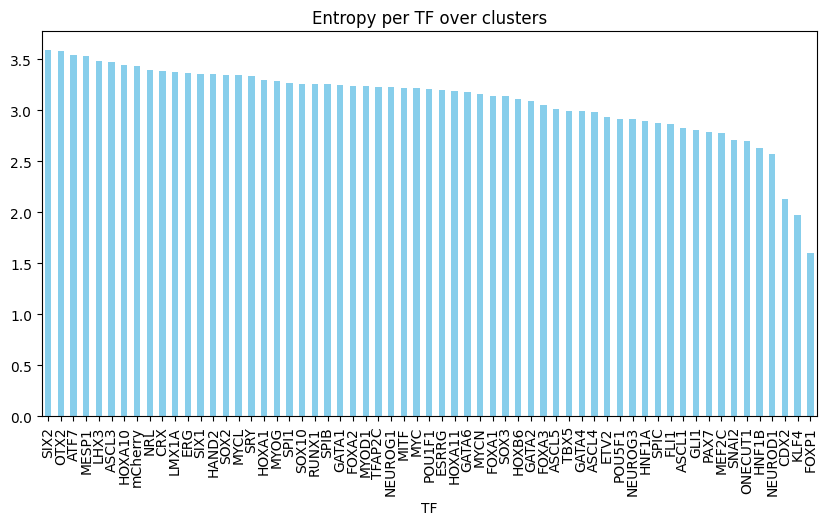

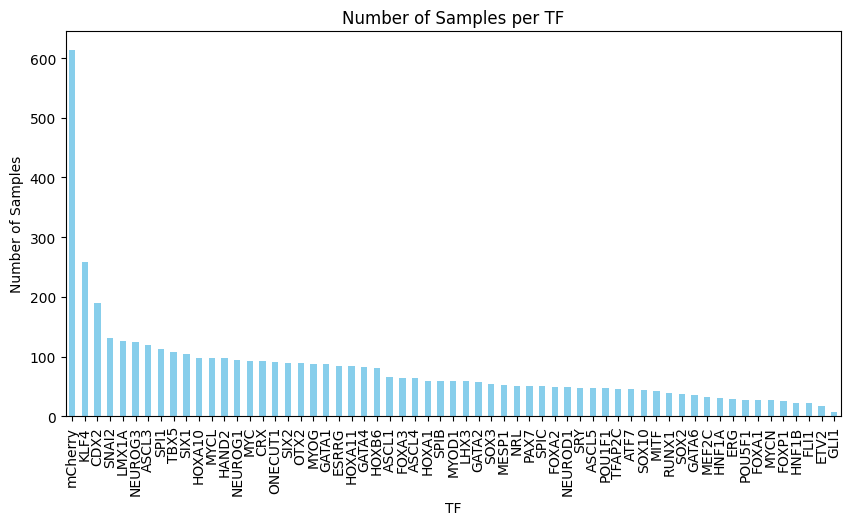

In [155]:
entropy_per_tf = calculate_entropy_per_tf(adata)
# print ordered histogram per TF
entropy_per_tf = entropy_per_tf.sort_values(ascending=False)
# plot histogram
entropy_per_tf.plot(kind='bar', figsize=(10, 5), color='skyblue', title='Entropy per TF over clusters')

# Count the number of samples per TF
sample_counts = adata.obs['TF'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 5))
sample_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Samples per TF')
plt.xlabel('TF')
plt.ylabel('Number of Samples')
plt.show()

<AxesSubplot: title={'center': 'TFs as a function of value_counts()'}>

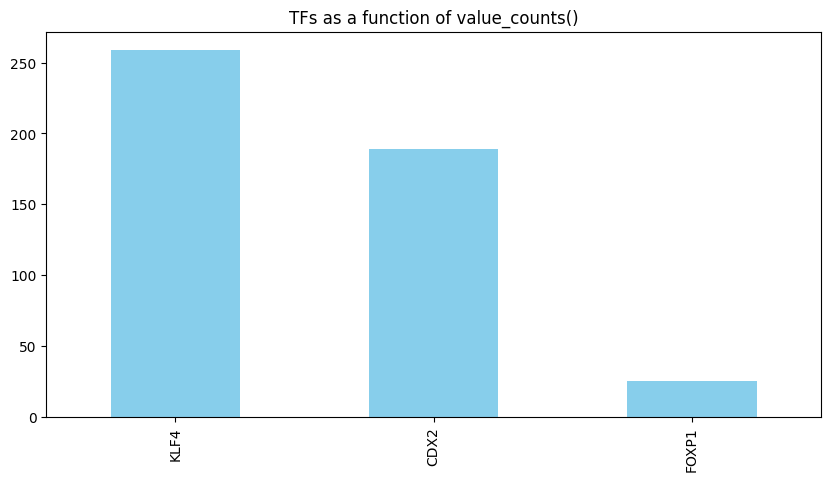

In [156]:
adata = select_samples(adata, COUNT_VAR=5, ENTROPY_VAR=2.5)

adata.obs['TF'].value_counts().plot(kind='bar', figsize=(10, 5), color='skyblue', title='TFs as a function of value_counts()')

### save

In [157]:
adata.write_h5ad('../data/cleant/GSM33088__-SUESS.h5ad')
adata
del adata

## TF atlas

In [158]:
adata = sc.read_h5ad('../data/GSE217460_210322_TFAtlas_differentiated_raw.h5ad')
tdata = sc.read_h5ad('../data/GSE217460_210322_TFAtlas_differentiated.h5ad')

adata.obsm["X_pca"] = tdata.obsm['X_pca']
adata.obsm["X_pca_harmony"] = tdata.obsm["X_pca_harmony"]

del tdata

In [159]:
tf = "PAX2"

# Ensure the 'TF' column is treated as a string
adata.obs["TF"] = adata.obs["TF"].astype(str)

# Extract just the TF part after the '-' and create a new column (e.g., "New_TF")
adata.obs["New_TF"] = adata.obs["TF"].str.split("-").str[-1]

# sanity check
if tf in adata.obs["New_TF"].unique():
    print("TF is in the list")
else:
    print("TF is not in the list")

# # If you want to replace the original 'TF' column with these new categories:
adata.obs["TF"] = adata.obs["New_TF"]
adata.obs = adata.obs.drop(columns=["New_TF"])

adata.obs["batch"] = adata.obs["batch"].replace({0: "TFatlas_1", 1: "TFatlas_2"})

TF is in the list


In [160]:
adata.X
if not sp.issparse(adata.X):
    adata.X = sp.csr_matrix(adata.X)
else:
    adata.X = adata.X


### preprocess

In [161]:
adata = preprocess(adata)

### perform PCA and plot UMAP

currently commented because the results were really bad? 

In [162]:
# sc.pp.pca(adata, svd_solver="auto") # uses ARpack
# import scanpy as sc
# from harmony import harmonize


# ## should I use batch of batchTF here? 
# adata.obsm["X_pca_harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="batch") # can use GPU

/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


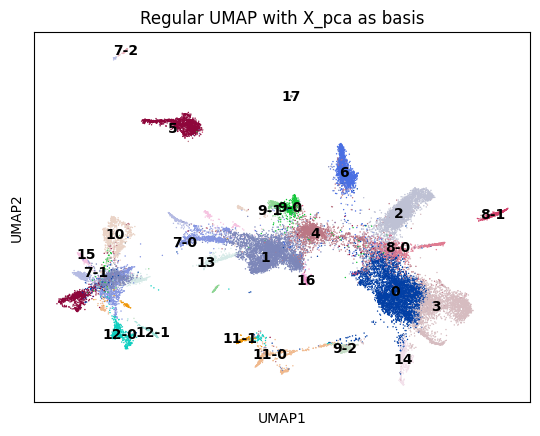

/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


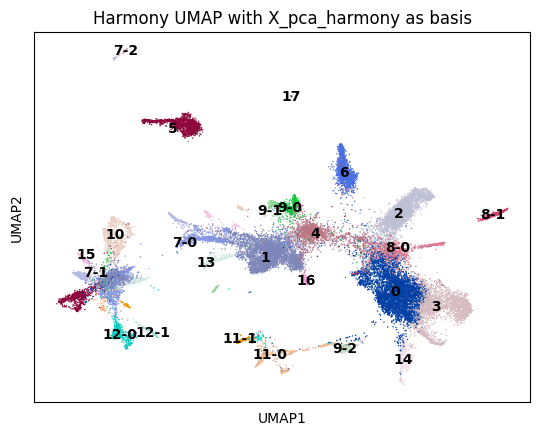

In [163]:
# Plot UMAP for regular PCA
plot_umap(adata, pca_key='X_pca', umap_key='umap', title_prefix='Regular')

# Plot UMAP for Harmony integrated PCA
plot_umap(adata, pca_key='X_pca_harmony', umap_key='X_umap_PCA_Harmony', title_prefix='Harmony')

### cell selections

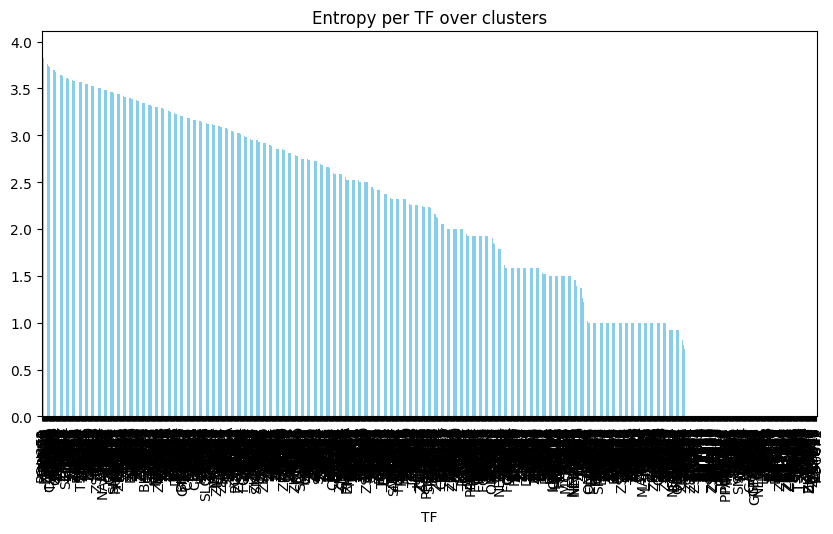

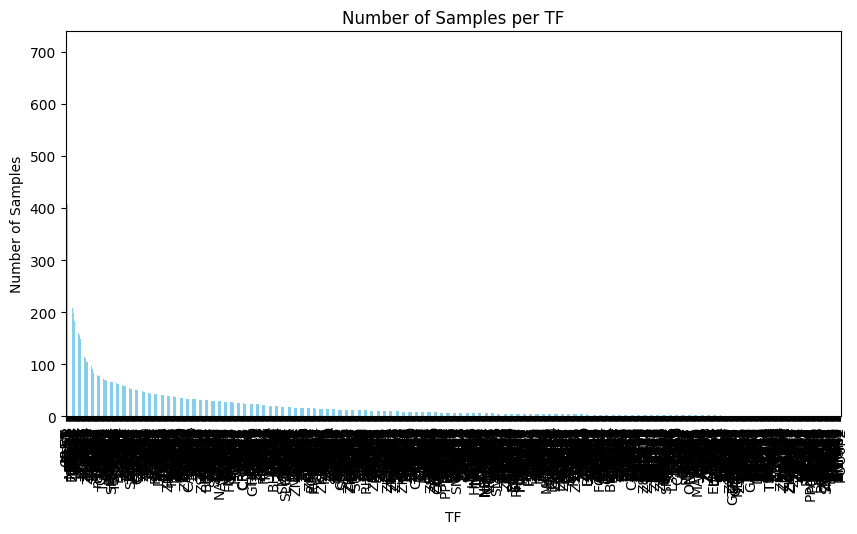

In [164]:
entropy_per_tf = calculate_entropy_per_tf(adata)
# print ordered histogram per TF
entropy_per_tf = entropy_per_tf.sort_values(ascending=False)
# plot histogram
entropy_per_tf.plot(kind='bar', figsize=(10, 5), color='skyblue', title='Entropy per TF over clusters')

# Count the number of samples per TF
sample_counts = adata.obs['TF'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 5))
sample_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Samples per TF')
plt.xlabel('TF')
plt.ylabel('Number of Samples')
plt.show()

<AxesSubplot: title={'center': 'TFs as a function of value_counts()'}>

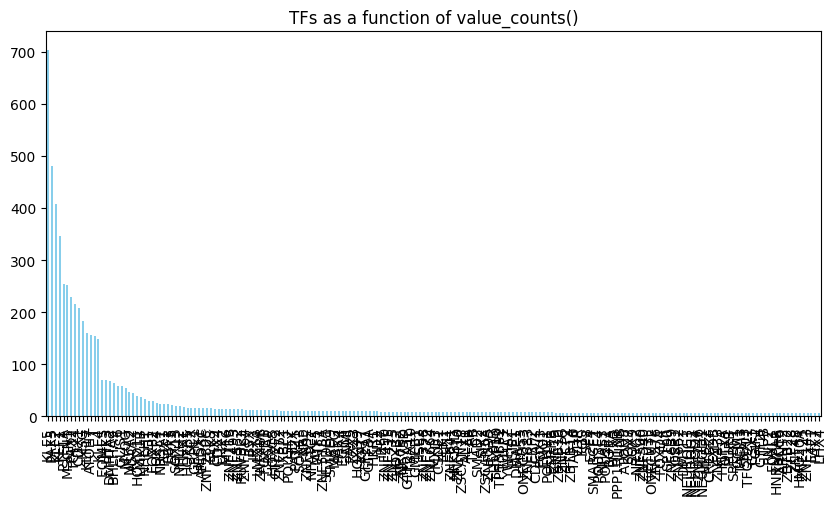

In [165]:
adata = select_samples(adata)

adata.obs['TF'].value_counts().plot(kind='bar', figsize=(10, 5), color='skyblue', title='TFs as a function of value_counts()')

### save 

In [166]:
adata.write_h5ad('../data/cleant/GSE217460_210322_TFAtlas.h5ad')
adata
del adata


In [167]:
TFdata = sc.read_h5ad('../data/cleant/GSE217460_210322_TFAtlas.h5ad')
SUESSdata = sc.read_h5ad('../data/cleant/GSM33088__-SUESS.h5ad')

In [168]:
TFdata
TFdata.obs["batch"]

R1.87,R2.96,R3.25,P1.22-0-0      0
R1.45,R2.92,R3.19,P1.62-1-1-0    0
R1.23,R2.88,R3.06,P1.47-3-2-0    0
R1.85,R2.43,R3.84,P1.55-0-3-0    0
R1.11,R2.74,R3.09,P1.40-2-4-0    0
                                ..
R1.49,R2.10,R3.18,P1.55-0-3-0    0
R1.07,R2.01,R3.25,P1.08-2-3-0    0
R1.40,R2.69,R3.50,P1.24-0-4-0    0
R1.80,R2.42,R3.65,P1.24-0-4-0    0
R1.57,R2.23,R3.56,P1.40-2-4-0    0
Name: batch, Length: 6203, dtype: category
Categories (2, object): ['0', '1']

In [169]:
SUESSdata # this one is now very very small because i've been extremely strict on the entropy
SUESSdata.obs["batch"]

AAACCTGAGATAGCAT    GSM3308846_up-tf-endo-sample1
AACACGTCACGCGAAA    GSM3308846_up-tf-endo-sample1
AACCGCGGTCTTGATG    GSM3308846_up-tf-endo-sample1
AACTCAGAGGTGATAT    GSM3308846_up-tf-endo-sample1
AACTCCCTCGTTGACA    GSM3308846_up-tf-endo-sample1
                                ...              
TTTACTGAGGCTAGAC    GSM3308847_up-tf-endo-sample2
TTTACTGTCATCATTC    GSM3308847_up-tf-endo-sample2
TTTCCTCAGCCAGTTT    GSM3308847_up-tf-endo-sample2
TTTGCGCGTAAATGAC    GSM3308847_up-tf-endo-sample2
TTTGTCACATAGTAAG    GSM3308847_up-tf-endo-sample2
Name: batch, Length: 473, dtype: category
Categories (2, object): ['GSM3308846_up-tf-endo-sample1', 'GSM3308847_up-tf-endo-sample2']

## combining the two atlases

In [170]:
common_genes = TFdata.var_names.intersection(SUESSdata.var_names)

sc.pp.highly_variable_genes(TFdata, n_top_genes=2000)
sc.pp.highly_variable_genes(SUESSdata, n_top_genes=2000)


hv_genes_common = TFdata.var_names[TFdata.var.highly_variable].intersection(
    SUESSdata.var_names[SUESSdata.var.highly_variable]
).intersection(common_genes)

# Step 3: Subset both AnnData objects to include only the highly variable common genes and necessary metadata
adata1_sub = TFdata[:, hv_genes_common].copy()
adata2_sub = SUESSdata[:, hv_genes_common].copy()

# Step 4: Concatenate the AnnData objects
# Ensure that you concatenate along the observations axis and keep only the metadata you care about
adata_combined = sc.concat([adata1_sub, adata2_sub], join='outer', index_unique=None)

# Optional: Clean up and reorder metadata to keep only what you care about
adata_combined.obs = adata_combined.obs[['TF', 'batch']]

print(adata_combined)

AnnData object with n_obs × n_vars = 6676 × 263
    obs: 'TF', 'batch'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap_PCA_Harmony', 'umap', 'X_diffmap'


In [177]:
# print(adata_combined.obs['TF'].value_counts())
print(adata_combined.obs['batch'].value_counts())

0                                4935
1                                1268
GSM3308847_up-tf-endo-sample2     310
GSM3308846_up-tf-endo-sample1     163
Name: batch, dtype: int64


In [180]:
adata_combined.obs['TF'].value_counts()

adata_combined.write_h5ad('../data/cleant/GSE217460_210322_TFAtlas-SUESS.h5ad')
